# Let's run a CS-VQE simulation

In [1]:
import json
import numpy as np

with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiOH_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'NaH_STO-3G_SINGLET', 'LiH_3-21G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'HF_3-21G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2-_STO-3G_SINGLET', 'BH3_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'NH4+_STO-3G_SINGLET', 'MgH2_STO-3G_SINGLET', 'Mg_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-

Build the molecule:

In [2]:
from symmer.chem import MoleculeBuilder
from symmer.projection import QubitTapering, CS_VQE, StabilizerIdentification

speciesname = 'Be_STO-3G_SINGLET'
print(speciesname)
# build the molecule
mol_data = molecule_geometries[speciesname]
atoms  = mol_data['atoms']
coords = mol_data['coords']
charge = mol_data['charge']
basis = mol_data['basis']
geometry = list(zip(atoms, coords))
molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=0, run_fci=True, print_info=True)

Be_STO-3G_SINGLET
Molecule geometry:
Be	0	0	0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -14.351880476202023
MP2 energy:  -14.376238850841515
CCSD energy: -14.403650751752787
FCI energy:  -14.403655108067682


Number of qubits: 10


Taper the Hamiltonian:

In [3]:
# taper the Hamiltonian
qubit_tapering = QubitTapering(molecule.H_q)
hf_array = molecule.H_fermion.hf_comp_basis_state
qubit_tapering.stabilizers.update_sector(hf_array)
ham_tap = qubit_tapering.taper_it(ref_state=hf_array)
ucc_tap = qubit_tapering.taper_it(aux_operator=molecule.UCC_q, ref_state=hf_array)
hf_tapered = qubit_tapering.tapered_ref_state

print(f'Qubit tapering permitted a reduction of {molecule.H_q.n_qubits} -> {ham_tap.n_qubits} qubits\n')
print('The following stabilizers were identified:\n')
print(qubit_tapering.stabilizers)

Qubit tapering permitted a reduction of 10 -> 5 qubits

The following stabilizers were identified:

 1 ZIZIIZIZIZ 
 1 IZIZIZIZIZ 
 1 IIIIZZIIII 
 1 IIIIIIZZII 
 1 IIIIIIIIZZ


# Particle number preservation under projection...

In [4]:
from symmer.utils import exact_gs_energy
from symmer.symplectic import array_to_QuantumState

gs_energy, gs_vector = exact_gs_energy(molecule.H_q.to_sparse_matrix)
print(gs_energy - molecule.fci_energy)
qs = array_to_QuantumState(gs_vector).cleanup(zero_threshold=1e-5)
print(qs)
hf_array

-2.6645352591003757e-14
 0.0003920040+0.0003822498j |0000001111> +
 0.0003920040+0.0003822498j |0000110011> +
 0.0003920040+0.0003822498j |0000111100> +
-0.0005766060-0.0005622584j |0011000011> +
-0.0005766060-0.0005622584j |0011001100> +
-0.0005766060-0.0005622584j |0011110000> +
-0.0024074631-0.0023475584j |0110000011> +
-0.0024074631-0.0023475584j |0110001100> +
-0.0024074631-0.0023475584j |0110110000> +
 0.0024074631+0.0023475584j |1001000011> +
 0.0024074631+0.0023475584j |1001001100> +
 0.0024074631+0.0023475584j |1001110000> +
-0.1334643808-0.1301434002j |1100000011> +
-0.1334643808-0.1301434002j |1100001100> +
-0.1334643808-0.1301434002j |1100110000> +
 0.6775852219+0.6607249380j |1111000000>


array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [5]:
gs_energy, gs_vector = exact_gs_energy(molecule.H_q.perform_rotations(qubit_tapering.stabilizers.stabilizer_rotations).to_sparse_matrix)
print(gs_energy - molecule.fci_energy)
qs_rot = array_to_QuantumState(gs_vector).cleanup(zero_threshold=1e-5)
print(qs_rot)
hf_array

-7.105427357601002e-15
-0.0170612252+0.0281931467j |0000000001> +
 0.0170612252-0.0281931467j |0000000011> +
-0.0170612252+0.0281931467j |0000000100> +
-0.0000501113+0.0000828073j |0000000101> +
 0.0170612252-0.0281931467j |0000000110> +
 0.0000501113-0.0000828073j |0000000111> +
 0.0170612252-0.0281931467j |0000001001> +
-0.0170612252+0.0281931467j |0000001011> +
 0.0170612252-0.0281931467j |0000001100> +
 0.0000501113-0.0000828073j |0000001101> +
-0.0170612252+0.0281931467j |0000001110> +
-0.0000501113+0.0000828073j |0000001111> +
-0.0170612252+0.0281931467j |0000010000> +
-0.0000501113+0.0000828073j |0000010001> +
 0.0170612252-0.0281931467j |0000010010> +
 0.0000501113-0.0000828073j |0000010011> +
-0.0000501113+0.0000828073j |0000010100> +
 0.0000501113-0.0000828073j |0000010110> +
 0.0170612252-0.0281931467j |0000011000> +
 0.0000501113-0.0000828073j |0000011001> +
-0.0170612252+0.0281931467j |0000011010> +
-0.0000501113+0.0000828073j |0000011011> +
 0.0000501113-0.0000828073j |00

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [6]:
rot, angle = zip(*qubit_tapering.stabilizers.stabilizer_rotations)
prod = rot[0]**0
for r in rot[::-1]:
    prod *= (r**0+r.multiply_by_constant(-1j)).multiply_by_constant(1/np.sqrt(2))
    
print(prod*qs)

-0.0235933922-0.0230063202j |0000000001> +
-0.0235933922-0.0230063202j |0000000011> +
-0.0235933922-0.0230063202j |0000000100> +
 0.0000692972+0.0000675728j |0000000101> +
-0.0235933922-0.0230063202j |0000000110> +
 0.0000692972+0.0000675728j |0000000111> +
-0.0235933922-0.0230063202j |0000001001> +
-0.0235933922-0.0230063202j |0000001011> +
-0.0235933922-0.0230063202j |0000001100> +
 0.0000692972+0.0000675728j |0000001101> +
-0.0235933922-0.0230063202j |0000001110> +
 0.0000692972+0.0000675728j |0000001111> +
-0.0235933922-0.0230063202j |0000010000> +
 0.0000692972+0.0000675728j |0000010001> +
-0.0235933922-0.0230063202j |0000010010> +
 0.0000692972+0.0000675728j |0000010011> +
 0.0000692972+0.0000675728j |0000010100> +
 0.0000692972+0.0000675728j |0000010110> +
-0.0235933922-0.0230063202j |0000011000> +
 0.0000692972+0.0000675728j |0000011001> +
-0.0235933922-0.0230063202j |0000011010> +
 0.0000692972+0.0000675728j |0000011011> +
 0.0000692972+0.0000675728j |0000011100> +
 0.00006929

In [7]:
import numpy as np
from symmer.utils import symplectic_cleanup
symplectic_cleanup(qs_rot.state_op.symp_matrix[:,qubit_tapering.free_qubit_indices], qs_rot.coeff_vector)

(array([[0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 1],
        [0, 0, 1, 1, 0],
        [0, 1, 0, 0, 1],
        [0, 1, 0, 1, 0],
        [0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 1, 0],
        [1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 0, 0, 1],
        [1, 1, 0, 1, 0],
        [1, 1, 1, 0, 0]]),
 array([ 0.+0.j,  0.+0.j,  0.-0.j, -0.+0.j,  0.+0.j, -0.-0.j,  0.-0.j,
        -0.+0.j,  0.+0.j,  0.+0.j,  0.-0.j, -0.+0.j, -0.+0.j,  0.-0.j,
         0.-0.j, -0.-0.j]))

In [8]:
gs_energy, gs_vector = exact_gs_energy(ham_tap.to_sparse_matrix)
print(gs_energy - molecule.fci_energy)
print(array_to_QuantumState(gs_vector).cleanup(zero_threshold=1e-5))
hf_tapered

1.7763568394002505e-15
-0.1864136410+0.0000000000j |00001> +
-0.1864136410+0.0000000000j |00010> +
-0.0005475235+0.0000000000j |00011> +
-0.1864136410+0.0000000000j |00100> +
-0.0005475235+0.0000000000j |00101> +
-0.0005475235+0.0000000000j |00110> +
-0.0033625747+0.0000000000j |01001> +
-0.0033625747+0.0000000000j |01010> +
-0.0033625747+0.0000000000j |01100> +
 0.0033625747+0.0000000000j |10001> +
 0.0033625747+0.0000000000j |10010> +
 0.0033625747+0.0000000000j |10100> +
-0.9464032844+0.0000000000j |11000> +
-0.0008053626+0.0000000000j |11001> +
-0.0008053626+0.0000000000j |11010> +
-0.0008053626+0.0000000000j |11100>


array([1, 1, 0, 0, 0])

Build CS-VQE model and find optimal stabilizers:

In [9]:
n_qubits = 3
# CS-VQE and stabilizer identification
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
CC_stabilizers = StabilizerIdentification(ucc_tap)
S = CC_stabilizers.symmetry_basis_by_subspace_dimension(n_qubits)
ham_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False)

In [10]:
S

 1 ZIZZZ 
 1 IZZZZ

In [11]:
from symmer.utils import exact_gs_energy
gs_energy, gs_vector = exact_gs_energy(ham_cs.to_sparse_matrix)
print(f'CS error = {gs_energy - molecule.fci_energy}\n')
print(array_to_QuantumState(gs_vector).cleanup(zero_threshold=1e-5))
hf_tapered[cs_vqe.free_qubit_indices]

CS error = 0.0003265059338524168

-0.9461446877+0.0000000000j |000> +
-0.1869137323+0.0000000000j |001> +
-0.1869137323+0.0000000000j |010> +
-0.1869137323+0.0000000000j |100>


array([0, 0, 0])

In [12]:
ham_cs.to_PauliSumOp

PauliSumOp(SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ', 'IIX', 'ZZX', 'IXI', 'ZXZ', 'IXX', 'IYY', 'XII', 'XZZ', 'XIX', 'YIY', 'XXI', 'YYI'],
              coeffs=[-12.488598  +0.j,  -0.85829425+0.j,  -0.85829425+0.j,   0.02304318+0.j,
  -0.85829425+0.j,   0.02304318+0.j,   0.02304318+0.j,   0.64247074+0.j,
  -0.04340449+0.j,  -0.04340449+0.j,  -0.04340449+0.j,  -0.04340449+0.j,
   0.01212469+0.j,   0.01212469+0.j,  -0.04340449+0.j,  -0.04340449+0.j,
   0.01212469+0.j,   0.01212469+0.j,   0.01212469+0.j,   0.01212469+0.j]), coeff=1.0)

# Build an Ansatz

In [13]:
from symmer.symplectic import AnsatzOp, ObservableOp

ucc_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False, aux_operator=ucc_tap)
ref_cs = hf_tapered[cs_vqe.free_qubit_indices]
anz_cs = AnsatzOp(ucc_cs.symp_matrix, ucc_cs.coeff_vec)

obs = ObservableOp(ham_cs.symp_matrix, ham_cs.coeff_vec)
vqe_result = obs.VQE(
    ansatz_op=anz_cs, 
    ref_state=ref_cs
)

opt_params = vqe_result[0]['x']
print(anz_cs)
vqe_result[0]['fun'] - molecule.fci_energy

-0.098 IIY +
-0.098 ZZY +
-0.096 IYI +
-0.096 ZYZ +
-0.094 YII +
-0.094 YZZ


0.0003265823239786414

In [14]:
from qiskit import QuantumCircuit
ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
ansatz = ansatz.compose(anz_cs.to_QuantumCircuit(bind_params=False))
ansatz.draw()

░ ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░ ┌─────┐┌───┐          »
q_0: ─░─┤ Sdg ├┤ H ├┤ Rz(-2*P[0]) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■───────»
      ░ └─────┘└───┘└─────────────┘└───┘└───┘ ░ └─────┘└───┘┌─┴─┐     »
q_1: ─░───────────────────────────────────────░─────────────┤ X ├──■──»
      ░                                       ░             └───┘┌─┴─┐»
q_2: ─░───────────────────────────────────────░──────────────────┤ X ├»
      ░                                       ░                  └───┘»
«                              ┌───┐┌───┐ ░                                 »
«q_0: ──────────────────────■──┤ H ├┤ S ├─░─────────────────────────────────»
«                         ┌─┴─┐└───┘└───┘ ░ ┌─────┐┌───┐┌─────────────┐┌───┐»
«q_1: ─────────────────■──┤ X ├───────────░─┤ Sdg ├┤ H ├┤ Rz(-2*P[2]) ├┤ H ├»
«     ┌─────────────┐┌─┴─┐└───┘           ░ └─────┘└───┘└─────────────┘└───┘»
«q_2: ┤ Rz(-2*P[1]) ├┤ X ├────────────────░─────────────────────────────────»
«     └─────────────┘└───┘                ░                                 »
«           ░                                                           ░ »
«q_0: ──────░───────────────■─────────────────────────────■─────────────░─»
«     ┌───┐ ░ ┌─────┐┌───┐┌─┴─┐                         ┌─┴─┐┌───┐┌───┐ ░ »
«q_1: ┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├──■───────────────────■──┤ X ├┤ H ├┤ S ├─░─»
«     └───┘ ░ └─────┘└───┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐└───┘└───┘└───┘ ░ »
«q_2: ──────░──────────────────┤ X ├┤ Rz(-2*P[3]) ├┤ X ├────────────────░─»
«           ░                  └───┘└─────────────┘└───┘                ░ »
«                                           ░                                 »
«q_0: ──────────────────────────────────────░────■────────────────────────────»
«                                           ░  ┌─┴─┐                          »
«q_1: ──────────────────────────────────────░──┤ X ├────────■─────────────────»
«     ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░ ┌┴───┴┐┌───┐┌─┴─┐┌─────────────┐»
«q_2: ┤ Sdg ├┤ H ├┤ Rz(-2*P[4]) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├┤ Rz(-2*P[5]) ├»
«     └─────┘└───┘└─────────────┘└───┘└───┘ ░ └─────┘└───┘└───┘└─────────────┘»
«                     ░ 
«q_0: ───────■────────░─
«          ┌─┴─┐      ░ 
«q_1: ──■──┤ X ├──────░─
«     ┌─┴─┐├───┤┌───┐ ░ 
«q_2: ┤ X ├┤ H ├┤ S ├─░─
«     └───┘└───┘└───┘ ░

In [15]:
#from qiskit.circuit.library import EfficientSU2, PauliTwoDesign, ExcitationPreserving
#from qiskit.circuit import Parameter
#ansatz = PauliTwoDesign(num_qubits=n_qubits, reps=5, insert_barriers=True)
#ansatz = EfficientSU2(num_qubits=n_qubits, reps=2, entanglement="linear", insert_barriers=True)
#ansatz = QuantumCircuit(3)
#for i in np.where(hf_tapered[cs_vqe.free_qubit_indices])[0]:
#    ansatz.x(n_qubits-1-i)
#ansatz.rx(Parameter('x'),0)
#ansatz.barrier()
#ansatz = ansatz.compose(ExcitationPreserving(3))
#ansatz.decompose().draw()#"mpl", style="iqx")

In [16]:
from qiskit.quantum_info import Statevector
from symmer.symplectic import QuantumState
qc = ansatz.bind_parameters(opt_params)
psi = Statevector.from_instruction(qc).to_dict()
state_matrix, coeff_vec = zip(*[([int(i) for i in bstring], coeff) for bstring, coeff in psi.items()])
state_matrix = np.array(state_matrix)
coeff_vec = np.array(coeff_vec)

psi = QuantumState(state_matrix, coeff_vec)
psi.conjugate * ham_cs * psi - molecule.fci_energy

(0.00036456488604841297-4.5078947556682104e-33j)

In [17]:
prog = service.programs()[8]

NameError: name 'service' is not defined

In [18]:
prog

NameError: name 'prog' is not defined

In [19]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler
from scipy.optimize import minimize

service = QiskitRuntimeService(channel='ibm_quantum')
backend_name = 'ibmq_qasm_simulator' #'ibm_nairobi'
options = {'backend_name':backend_name}

n_shots = 2**14

def _gradient(x, estimator):
    upper_params = [x+np.pi/4*np.eye(1,len(x),i)[0] for i in range(len(x))]
    lower_params = [x-np.pi/4*np.eye(1,len(x),i)[0] for i in range(len(x))]
    
    upper_energy = estimator(
        [0]*len(x), 
        [0]*len(x), 
        upper_params, 
        shots=n_shots)
    
    lower_energy = estimator(
        [0]*len(x), 
        [0]*len(x), 
        upper_params, 
        shots=n_shots)
    
    return upper_energy.values - lower_energy.values

def _energy(x, estimator):
    energy = estimator(
        [0],[0],[x],
        shots=n_shots)
    return energy.values

def VQE(
    ansatz: QuantumCircuit,
    init_params: np.array = None,
    self = ham_cs,
    optimizer:  str   = 'BFGS',
    maxiter:    int   = 10, 
    opt_tol:    float = None
    ):
    """ 
    Rcommended optimizers:
        - SLSQP  (gradient-descent, does not evaluate Jacobian at each iterate like BFGS or CG so is faster)
        - COBYLA (gradient-free)
    """
    interim_values = {'values':[], 'params':[], 'gradients':[], 'count':0}
   
    if init_params is None:
        init_params = np.zeros(ansatz.num_parameters)
    
    with Estimator(
        circuits=[ansatz],
        observables=[self.to_PauliSumOp],
        service=service,
        options=options
        ) as estimator:
        
        def energy(x):
            interim_values['count']+=1
            energy = _energy(x, estimator=estimator)
            print(energy)
            interim_values['params'].append((interim_values['count'], x))
            interim_values['values'].append((interim_values['count'], energy))
            return energy

        def gradient(x):
            Delta = _gradient(x, estimator=estimator)
            interim_values['gradients'].append((interim_values['count'], Delta))
            return Delta

        vqe_result = minimize(
            fun=energy, 
            jac=gradient,
            x0=init_params,
            method=optimizer,
            tol=opt_tol,
            options={'maxiter':maxiter}
        )

    return vqe_result, interim_values

In [20]:
vqe_result, interim_values = VQE(ansatz, optimizer='SLSQP')
vqe_result

[-14.35244855]
[-14.34652545]
[-14.35074354]
[-14.35282255]
[-14.30440808]
[-14.35098]
[-14.35169762]
[-14.35500641]
[-14.32904622]
[-14.35120147]
[-14.35253932]
[-14.35062856]
[-14.35006798]
[-14.3511638]
[-14.35343975]
[-14.35152735]
[-14.35223291]
[-14.35249646]
[-14.35160337]


     fun: array([-14.35160337])
     jac: array([-0.0043181 , -0.01074643, -0.00700095, -0.00765023, -0.01433237,
       -0.00262988])
 message: 'Optimization terminated successfully'
    nfev: 19
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([ 0.00011419, -0.00006384,  0.00019091, -0.00017924,  0.00014228,
        0.00021264])

In [1311]:
vqe_result['fun'] - molecule.fci_energy

0.05316617181472871

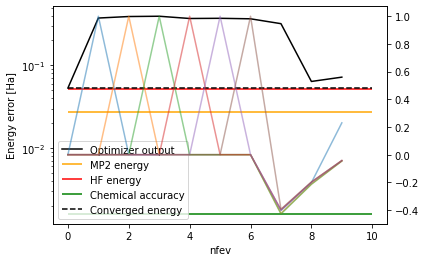

In [1312]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
X,Y = zip(*interim_values['values'])
X, Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 0, len(Y), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 0, len(Y), color='red', label='HF energy')
axis.hlines(0.0016, 0, len(Y), color='green', label='Chemical accuracy')

axis.plot(abs(Y - molecule.fci_energy), color='black', label='Optimizer output')
axis.hlines(vqe_result['fun'] - molecule.fci_energy, 0, len(Y), color='black', label='Converged energy', ls='--')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
axis.set_yscale('log')

axis_param = axis.twinx()
for Y_param in list(zip(*interim_values['params']))[1:]:
    axis_param.plot(Y_param, alpha=0.5)

axis.legend()
plt.show()

In [1457]:
from qiskit import IBMQ
provider = IBMQ.load_account()
sim = provider.backends.ibmq_qasm_simulator

RequestsApiError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [1456]:
import sys

sys.path.insert(0, "..")  # Add source_program directory to the path

from program_source.hello_world import hello_world
from qiskit import Aer
from qiskit.providers.ibmq.runtime import UserMessenger
#from qiskit.primitives import Estimator
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler
from qiskit_ibm_runtime import RuntimeEncoder, RuntimeDecoder#, UserMessenger

backend = Aer.get_backend("qasm_simulator")
self = ham_cs

def main(backend, user_messenger, **kwargs) -> Any:
    """Main entry point of the program.

    Args:
        backend (qiskit.providers.Backend): Backend to submit the circuits to.
        user_messenger (qiskit.providers.ibmq.runtime.UserMessenger): Used to communicate with the
            program consumer.
        kwargs: User inputs.

    Returns:
        Final result of the program.
    """
    interim_values = {'values':[], 'params':[], 'gradients':[], 'count':0}
   
    service = QiskitRuntimeService(channel='ibm_quantum')
    backend_name = kwargs.pop("backend_name", 1)
    init_params = kwargs.pop("init_params", 1)
    maxiter = kwargs.pop("maxiter", 1)
    optimizer = kwargs.pop("optimizer", 1)
    n_shots = kwargs.pop("n_shots", 1)

    if init_params is None:
        init_params = np.zeros(ansatz.num_parameters)
        
    estimator = Estimator(
            circuits=[ansatz],
            observables=[self.to_PauliSumOp],
            service=service,
            options={'backend_name':backend}
            )

    def _energy(x):
        energy = estimator(
            [0],[0],[x],
            shots=n_shots
        )
        return energy.values

    def _gradient(x):
        upper_params = [x+np.pi/4*np.eye(1,len(x),i)[0] for i in range(len(x))]
        lower_params = [x-np.pi/4*np.eye(1,len(x),i)[0] for i in range(len(x))]

        upper_energy = estimator(
            [0]*len(x), 
            [0]*len(x), 
            upper_params, 
            shots=n_shots)

        lower_energy = estimator(
            [0]*len(x), 
            [0]*len(x), 
            upper_params, 
            shots=n_shots)

        return upper_energy.values - lower_energy.values

    def energy(x):
        interim_values['count']+=1
        energy = _energy(x)
        user_messenger.publish({"count": interim_values['count'], "error":energy[0]-molecule.fci_energy})
        interim_values['params'].append((interim_values['count'], x))
        interim_values['values'].append((interim_values['count'], energy))
        return energy

    def gradient(x):
        Delta = _gradient(x)
        interim_values['gradients'].append((interim_values['count'], Delta))
        return Delta

    vqe_result = minimize(
        fun=energy, 
        jac=gradient,
        x0=init_params,
        method=optimizer,
        #tol=opt_tol,
        options={'maxiter':maxiter}
    )
    
    estimator.close()
    
    return vqe_result, interim_values

inputs = {
    'init_params': None, 
    'maxiter': 30, 
    'optimizer':'COBYLA', 
    #'backend_name':'ibmq_qasm_simulator',
    'n_shots':2**10}

user_messenger = UserMessenger()
serialized_inputs = json.dumps(inputs, cls=RuntimeEncoder)
deserialized_inputs = json.loads(serialized_inputs, cls=RuntimeDecoder)

main(service.backends()[0], user_messenger, **deserialized_inputs)

/home/tweaving/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method COBYLA does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


QiskitBackendNotFoundError: "Backend <IBMBackend('ibmq_qasm_simulator')> cannot be found in anyhub/group/project for this account."

In [1431]:
job = backend.run(ansatz.bind_parameters(opt_params))

In [1451]:
job.result()

Result(backend_name='qasm_simulator', backend_version='0.9.1', qobj_id='672dc656-856b-42c8-b42b-f538485b422a', job_id='be48bd65-b0a3-4e64-90c6-136ba8bd2dcf', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(), header=QobjExperimentHeader(clbit_labels=[], creg_sizes=[], global_phase=0.0, memory_slots=0, metadata=None, n_qubits=3, name='circuit-11098', qreg_sizes=[['q', 3]], qubit_labels=[['q', 0], ['q', 1], ['q', 2]]), status=DONE, seed_simulator=1553592437, metadata={'parallel_state_update': 8, 'noise': 'ideal', 'measure_sampling': True, 'device': 'CPU', 'num_qubits': 0, 'parallel_shots': 1, 'remapped_qubits': False, 'method': 'stabilizer', 'active_input_qubits': [], 'num_clbits': 0, 'input_qubit_map': [], 'fusion': {'enabled': False}}, time_taken=3.7857e-05)], date=2022-06-21T18:13:13.301931, status=COMPLETED, status=QobjHeader(backend_name='qasm_simulator', backend_version='0.9.1'), metadata={'time_taken': 0.0004048280000000000

In [1437]:
ansatz.bind_parameters(opt_params).draw()

░ ┌─────┐┌───┐┌───────────────────────┐┌───┐┌───┐ ░ ┌─────┐┌───┐     »
q_0: ─░─┤ Sdg ├┤ H ├┤ Rz(0.195051178800347) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■──»
      ░ └─────┘└───┘└───────────────────────┘└───┘└───┘ ░ └─────┘└───┘┌─┴─┐»
q_1: ─░─────────────────────────────────────────────────░─────────────┤ X ├»
      ░                                                 ░             └───┘»
q_2: ─░─────────────────────────────────────────────────░──────────────────»
      ░                                                 ░                  »
«                                            ┌───┐┌───┐ ░             »
«q_0: ────────────────────────────────────■──┤ H ├┤ S ├─░─────────────»
«                                       ┌─┴─┐└───┘└───┘ ░ ┌─────┐┌───┐»
«q_1: ──■────────────────────────────■──┤ X ├───────────░─┤ Sdg ├┤ H ├»
«     ┌─┴─┐┌──────────────────────┐┌─┴─┐└───┘           ░ └─────┘└───┘»
«q_2: ┤ X ├┤ Rz(0.19505117880035) ├┤ X ├────────────────░─────────────»
«     └───┘└──────────────────────┘└───┘                ░             »
«                                         ░                       »
«q_0: ────────────────────────────────────░───────────────■───────»
«     ┌───────────────────────┐┌───┐┌───┐ ░ ┌─────┐┌───┐┌─┴─┐     »
«q_1: ┤ Rz(0.191400917938659) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├──■──»
«     └───────────────────────┘└───┘└───┘ ░ └─────┘└───┘└───┘┌─┴─┐»
«q_2: ────────────────────────────────────░──────────────────┤ X ├»
«                                         ░                  └───┘»
«                                                   ░             »
«q_0: ────────────────────────────────■─────────────░─────────────»
«                                   ┌─┴─┐┌───┐┌───┐ ░             »
«q_1: ───────────────────────────■──┤ X ├┤ H ├┤ S ├─░─────────────»
«     ┌───────────────────────┐┌─┴─┐└───┘└───┘└───┘ ░ ┌─────┐┌───┐»
«q_2: ┤ Rz(0.191400917938652) ├┤ X ├────────────────░─┤ Sdg ├┤ H ├»
«     └───────────────────────┘└───┘                ░ └─────┘└───┘»
«                                         ░                  »
«q_0: ────────────────────────────────────░────■─────────────»
«                                         ░  ┌─┴─┐           »
«q_1: ────────────────────────────────────░──┤ X ├────────■──»
«     ┌───────────────────────┐┌───┐┌───┐ ░ ┌┴───┴┐┌───┐┌─┴─┐»
«q_2: ┤ Rz(0.188031553237421) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├»
«     └───────────────────────┘└───┘└───┘ ░ └─────┘└───┘└───┘»
«                                              ░ 
«q_0: ────────────────────────────────■────────░─
«                                   ┌─┴─┐      ░ 
«q_1: ───────────────────────────■──┤ X ├──────░─
«     ┌───────────────────────┐┌─┴─┐├───┤┌───┐ ░ 
«q_2: ┤ Rz(0.188031553237419) ├┤ X ├┤ H ├┤ S ├─░─
«     └───────────────────────┘└───┘└───┘└───┘ ░

# Connect to the IBM runtime service

In [955]:
from qiskit_ibm_runtime import QiskitRuntimeService
# only run the following the first time you connect to the service
#token = "79d7ac8b5e8ccb0dc53055b301ee7f02eaa147024039f20d1c5af280fc066c6426739e194af6f7fa44c27004aa7ed9a22df031085512b2f97d77207b9c2534fb"
#QiskitRuntimeService.save_account(channel="ibm_quantum", token=token)
service = QiskitRuntimeService(channel='ibm_quantum')

In [956]:
for name in service.backends():
    print(f'{name.name} backend has {name.status().pending_jobs} queued jobs.')

ibmq_qasm_simulator backend has 5 queued jobs.
ibmq_armonk backend has 3 queued jobs.
ibmq_lima backend has 29 queued jobs.
ibmq_belem backend has 36 queued jobs.
ibmq_quito backend has 58 queued jobs.
simulator_statevector backend has 5 queued jobs.
simulator_mps backend has 5 queued jobs.
simulator_extended_stabilizer backend has 5 queued jobs.
simulator_stabilizer backend has 5 queued jobs.
ibmq_manila backend has 232 queued jobs.
ibm_nairobi backend has 26 queued jobs.
ibm_oslo backend has 24 queued jobs.


# Define the runtime inputs and submit a VQE job to the service

In [1148]:
backend_name = 'ibmq_qasm_simulator' #'ibm_nairobi'

options = {
    'backend_name': backend_name
}

optimizer = {
    "name": "QN-SPSA",  # leverage the Quantum Natural SPSA
    #'name': 'SPSA',  # set to ordinary SPSA
    "maxiter": 100,
    "resamplings": {1: 100},  # 100 samples of the QFI for the first step, then 1 sample per step
}

runtime_inputs = {
    'ansatz': ansatz,
    'initial_point': opt_params,
    'operator': ham_cs.to_PauliSumOp,
    'optimizer': optimizer,
    'measurement_error_mitigation': True,
    'shots': 2**14
}

prm_vals=[] # parameter settings
nrg_vals=[] # optimizer energy outputs
err_vals=[] # errors

def interim_results(job_id, results):
    try:
        index, prm, nrg, err = results
        prm_vals.append((index, prm))
        nrg_vals.append((index, nrg))
        err_vals.append((index, err))
    except:
        print('VQE complete')
    
job = service.run(
    program_id='vqe',
    options=options,
    inputs=runtime_inputs,
    instance='ibm-q/open/main',
    callback=interim_results
)

In [1161]:
print(f'Job ID: {job.job_id}')
print(f'Job status: {job.status()}')

Job ID: caot4anhrqeo3qj6mk8g
Job status: JobStatus.RUNNING


# raw data stream

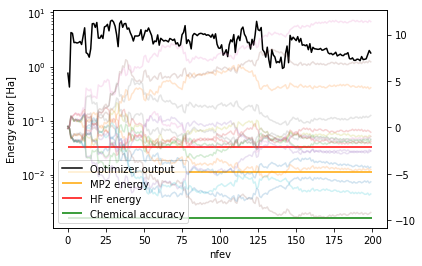

In [1169]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
X, Y = zip(*nrg_vals)
X, Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 0, len(Y), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 0, len(Y), color='red', label='HF energy')
axis.hlines(0.0016, 0, len(Y), color='green', label='Chemical accuracy')

axis.plot(abs(Y - molecule.fci_energy), color='black', label='Optimizer output')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
axis.set_yscale('log')

axis_param = axis.twinx()
for param in list(zip(*prm_vals))[1:]:
    axis_param.plot(param, alpha=0.2)

axis.legend()
plt.show()

# get the results and plot

In [1170]:
# Get results
result = job.result()
result['optimal_value'] - gs_energy

1.767255824543298

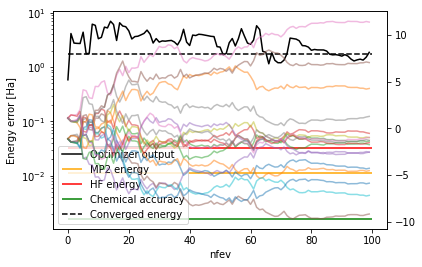

In [1171]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
Y = np.array(result['optimizer_history']['loss'])
#X, Y = zip(*nrg_vals)
#X, Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 0, len(Y), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 0, len(Y), color='red', label='HF energy')
axis.hlines(0.0016, 0, len(Y), color='green', label='Chemical accuracy')

axis.plot(abs(Y - molecule.fci_energy), color='black', label='Optimizer output')
axis.hlines(result['optimal_value'] - molecule.fci_energy, 0, len(Y), color='black', label='Converged energy', ls='--')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
axis.set_yscale('log')

axis_param = axis.twinx()
for param in zip(*result['optimizer_history']['params']):
    axis_param.plot(param, alpha=0.5)

axis.legend()
plt.show()

In [1024]:
result['eigenstate']

{'000': 0.15467960838455727,
 '001': 0.10597390598633231,
 '010': 0.10364452469860624,
 '011': 0.10825317547305482,
 '100': 0.5770682910193559,
 '101': 0.47030990447788784,
 '110': 0.4770105475773046,
 '111': 0.4008048543243956}

0.0007291720058191231

In [805]:
service.job(job.job_id).result()

KeyboardInterrupt: 